# Pre-requirements


# Libraries and some funtion defination

In [1]:
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# Bibliotecas Auxiliares
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()
import tensorflow_federated as tff
np.random.seed(0)
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from matplotlib import pyplot
from tensorflow import keras
from scipy import stats


import collections
import functools
import os
import time
import datetime

from sklearn.model_selection import train_test_split

# library to ignore the warnings
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

2023-06-13 14:44:27.355909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:44:27.928522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = np.array(matrix,dtype=object)
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

def showGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def create_dataset_time_series_with_one_output(X, y, window_time_steps=1, shift_step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - window_time_steps, shift_step):
        v = X.iloc[i:(i + window_time_steps)].values
        labels = y.iloc[i: i + window_time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
        
    if len(y.columns) == 1:
        return np.array(Xs), np.array(ys).reshape(-1, 1)
    else:
        return np.array(Xs), np.array(ys).reshape(-1, len(y.columns))

# Data Loading and Analysis

In this setion, we load analyse the data and do the transformations needed to prepare the data. As neural networks need numeric values, we must always be sure that all values are numbers.

In [3]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolders = "../data_2019_processed/"
            
allFolders = ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
            '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
            '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
            '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
            #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
            '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
            'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
            'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
            'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
            'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
            'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
            #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
            'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
            'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
            'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
            'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
            'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
            'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
            'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
            #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
            'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
            'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
            'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
            'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4', 
            'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
            'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
            'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
            'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
            'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
            'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']


# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']


In [4]:
print("Preparing test data")
# take the list of directories and concat them
def loadTestData(trainingDataSet):
    print(len(trainingDataSet), "datasets")
    for i in range(0,len(trainingDataSet)):
        print(i , "-", trainingDataSet[i])
        #print(trainingDataSet[i])
        if(i == 0):
            X_test = pd.read_csv(inputFolders+"student_"+trainingDataSet[i]+"_transformed.csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+trainingDataSet[i]+"_transformed.csv")
            X_test = pd.concat([X_test, dataset])
    # return the dataset        
    return X_test
         
# test data comprising 25% of the data. It must be fixed to all models being evaluated
X_test = loadTestData(testFolders)

# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
9 datasets
0 - PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc
1 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw
2 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI
3 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is
4 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw
5 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA
6 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw
7 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM
8 - ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY
<class 'pandas.core.frame.DataFrame'>
Int64Index: 136286 entries, 0 to 23751
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            136286 non-null  float64
 1   location            136286 non-null  float64
 2   timestamp           136286 non-null  float64
 3   time_to_next_alarm  136286 non-null  float64
 4   sound               136286 non-null  float64
 5   proximity           136286 non-null  float64
 6   phone_lock          13628

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake
...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake


In [5]:
# load cliend data to train
clientList = []

for i in range(0,len(trainFolders)):
    print (i," ", str(inputFolders)+"student_"+trainFolders[i]+"_transformed.csv") #_numeric
    # load client data
    dataset = pd.read_csv(inputFolders+"student_"+trainFolders[i]+"_transformed.csv")
    
    # print(dataset)
    y_train = dataset['class'].copy()
    
    # does not add datasets that dont have instances from both classes
    if y_train.sum() != 0 and (y_train.sum() != len(y_train)):
        clientList.append(dataset)
        
print("Total",(len(clientList)))

0   ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
1   ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
2   ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
3   ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
4   ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
5   ../data_2019_processed/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4_transformed.csv
6   ../data_2019_processed/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc_transformed.csv
7   ../data_2019_processed/student_Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U_transformed.csv
8   ../data_2019_processed/student_CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA_transformed.csv
9   ../data_2019_processed/student_DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc_transformed.csv
10   ../data_2019_processed/student_dQEFscjqnIlug8Tgq97JohhS

# Pre-processing

As we saw in the previous section, our dataset has 12 attributes, which we must prepare for the preprocessing task.

In order to do it, we are going to apply the following methodology:
- Feature Selection
- Data encoding transformation
- Feature data type transformation

From our dataset, we need to select the inputs and the outputs from our supervised learning process. From all 12 features, the class is the output, and the input does not need the timestamp and timestamp_text features because they are time-related value and (usually) does not give benefits to the neural network learning process. Thus, we create two new lists of values with the output classes we want: *inputFeatures* and *outputClasses*.

As we are using a process of classification and our output (class) can get two values awake and asleep, we can choose between two approaches:
(1) convert the class using label encoding (0 to awake and 1 to asleep). In this scenario, we use Binary Cross Entropy.
(2) convert the class using one-hot encoding, which becomes two different attributes. In this scenario, we use Categorical Cross Entropy.

In federated learning, I judge easier to use one-hot encoding in such a situation.

*Curiosity*: If you want to check the influence of timestamp in your dataset, you can use the pearson correlation or compare the training process results with and without it.

In [6]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]


In [7]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

# transform output to one_hot_encoding for the input dataset
for i in range(0,len(clientList)):
    clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
    #print (clientList[i])

In [8]:
X_test

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class,awake,asleep
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake,1,0
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake,1,0
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake,1,0
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake,1,0
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake,1,0
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake,1,0
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake,1,0
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake,1,0


As FedAvg uses float of 32 bits I recommend convert all values numeric values to float32


In [9]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136286 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            136286 non-null  float32
 1   location            136286 non-null  float32
 2   timestamp           136286 non-null  float64
 3   time_to_next_alarm  136286 non-null  float32
 4   sound               136286 non-null  float32
 5   proximity           136286 non-null  float32
 6   phone_lock          136286 non-null  float32
 7   light               136286 non-null  float32
 8   day_of_week         136286 non-null  float32
 9   minutes_day         136286 non-null  float32
 10  timestamp_text      136286 non-null  object 
 11  class               136286 non-null  object 
 12  awake               136286 non-null  float32
 13  asleep              136286 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 9.9+ MB


In [10]:
X_test

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class,awake,asleep
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake,1.0,0.0
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake,1.0,0.0
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake,1.0,0.0
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake,1.0,0.0
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake,1.0,0.0
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake,1.0,0.0
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake,1.0,0.0
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake,1.0,0.0


Now I need to transform the data into Tensor Slices. These slices can consider configurations like batch_size, window, and epochs.

The RNNs process data sequences, so we need to specify two properties: (1) the size of the windows; (2) the steps between the beginning of each window.

In [11]:
# General configuration
NUM_EPOCHS = 3
BATCH_SIZE = 32

TIME_SERIES_SIZE = 4   # Determines the window size. Ex (4,9)
TIME_STEP_SHIFT  = 1   # Determines specifies the number of steps to move the window forward at each iteration.

In [12]:
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transform to time series
X_test_data, y_test_label = create_dataset_time_series_with_one_output(    #timestamp
    X_test_data, 
    y_test_label, 
    TIME_SERIES_SIZE, 
    TIME_STEP_SHIFT
)

# transtorm data to tensor slices
client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data, y_test_label))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

print(client_test_dataset.element_spec)
client_test_dataset

(TensorSpec(shape=(None, 4, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))


2023-06-13 14:44:50.117163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:44:50.149198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 4, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [13]:
federated_training_data = []
# transform the data
for i in range(0,len(clientList)):
    # selects the data to train and test
    data   = clientList[i][inputFeatures]
    labels = clientList[i][outputClasses]
    # transform data to float32
    #data = transform_data_type(data)

    # transform to time series
    data, labels = create_dataset_time_series_with_one_output(    #timestamp
        data, 
        labels, 
        TIME_SERIES_SIZE, 
        TIME_STEP_SHIFT
    )

    # transform the data to tensor slices
    client_train_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    #client_train_dataset = tf.data.Dataset.from_tensor_slices((data.values, labels.values))
    # apply the configs
    client_train_dataset = client_train_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)
    # transform the data to
    federated_training_data.append(client_train_dataset)

# Model processing

In [14]:
def create_keras_model():
    model = keras.Sequential()
    model.add(LSTM(128,input_shape=(4, 9,))) #return_sequences=True, 
    #model.add(LSTM(128,input_shape=(2, 9,)))
    #model.add(keras.layers.Dropout(rate=0.5))
    #model.add(LSTM(64,activation="tanh"))
    #model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(2, activation='softmax'))#softmax,sigmoid
    
    return model

In [15]:
keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 70,914
Trainable params: 70,914
Non-trainable params: 0
_________________________________________________________________


2023-06-13 14:45:43.331513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:45:43.333099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:45:43.334460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    #keras_model = create_keras_model()
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model( #tff.learning.from_keras_model
      keras_model,
      input_spec=client_train_dataset.element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(), #BinaryCrossentropy
      metrics=[tf.keras.metrics.CategoricalAccuracy()]) #, tf.keras.metrics.Precision()

In [17]:
fed_avg_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),#client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

2023-06-13 14:45:44.775604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_input' with dtype double and shape [?,4,9]
	 [[{{node batch_input}}]]
2023-06-13 14:45:45.029354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_1' with dtype double and shape [?,4,9]
	 [[{{node args_1}}]]
2023-06-13 14:45:45.259009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' wit

In [18]:
print(fed_avg_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9,512],
      float32[128,512],
      float32[512],
      float32[128,2],
      float32[2]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[9,512],
    float32[128,512],
    float32[512],
    float32[128,2],
    float32[2]
  >
>@SERVER)


In [19]:
state = fed_avg_process.initialize()

2023-06-13 14:45:46.247125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:45:46.247179: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:45:46.247730: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:45:46.249209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:45:46.249226: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

# First Iteractions (rounds)

Now, we can start the learning process by selecting the users participating in the fed-avg aggregation process. Round 1 uses the data from the first ten users ([0:10]), and Round 2 uses the nine [10:19] remaining users for training.

We must highlight that it is an example. Nineteen users are too few to separate them, but it would be different if we considered much more users or data. In such scenarios, we must determine the selection strategy.

In [20]:
# now we can start the learning process by selecting the users that will participate from the learning process
result = fed_avg_process.next(state, federated_training_data[0:10])
state = result.state
metrics = result.metrics
print('round  1, metrics={}'.format(metrics))

2023-06-13 14:45:48.893637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:45:48.893684: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:45:48.893797: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:45:48.894324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:45:48.894339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

2023-06-13 14:45:49.103218: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:45:49.103300: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:45:49.103952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:45:49.103976: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-13 14:45:49.112344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open fi

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8675984), ('loss', 0.32827187), ('num_examples', 572901), ('num_batches', 17908)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


After the aggregation process is finished, we can see the results by loading the neural network weights from the global model.

In [21]:
#def keras_evaluate(state, round_num):
    # Take our global model weights and push them back into a Keras model to
    # use its standard `.evaluate()` method.
keras_model = create_keras_model()

keras_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])

# get neural network weights from the global model
weights = fed_avg_process.get_model_weights(state)
weights.assign_weights_to(keras_model)

# predict using the test data
yhat_probs = keras_model.predict(X_test_data)

maxX = yhat_probs.max()
minX = yhat_probs.min()
avgX = yhat_probs.mean()

print(maxX,minX,avgX,"\n")
print(yhat_probs)
# predict crisp classes for test set deprecated
#printMetrics(y_test,yhat_probs)

# as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
yhat_probs_rounded = yhat_probs.round()
print("\n",yhat_probs_rounded)

y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 
y_test_real_label = pd.DataFrame(data=y_test_label,columns=['awake','asleep']) 

# Instantiate the list that will contain the results
listOfMetrics = list()

print('')
print('awake')
res,resA = printMetrics(y_test_real_label['awake'],y_predicted_df['awake'])
listOfMetrics.append(res)
print('')
print('asleep')
res,resA = printMetrics(y_test_real_label['asleep'],y_predicted_df['asleep'])
listOfMetrics.append(res)
print('')
print('Global')
showGlobalMetrics(listOfMetrics)

2023-06-13 14:46:07.920067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:46:07.921513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:46:07.922673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  28/4259 [..............................] - ETA: 8s   

2023-06-13 14:46:08.217615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:46:08.219141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:46:08.220399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step
0.99110615 0.008893882 0.5 

[[0.9385747  0.06142533]
 [0.9402723  0.05972767]
 [0.9376285  0.06237146]
 ...
 [0.8892443  0.11075572]
 [0.8893811  0.11061884]
 [0.88948804 0.11051197]]

 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

awake
Accuracy: 0.814744
Precision: 0.814744
Recall: 1.000000
F1 score: 0.897916
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25247]
 [     0 111035]]

asleep
Accuracy: 0.816432
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111265      0]
 [ 25017      0]]

Global
2
accuracy:  0.8155882655082842
precision:  0.4073722134984811
recall:  0.5
f1_score:  0.44895821961288546
cohen_kappa_score:  0.0
roc_auc_score:  0.5


[0.8155882655082842, 0.4073722134984811, 0.5, 0.44895821961288546, 0.0, 0.5]

In [22]:
result = fed_avg_process.next(state, federated_training_data[10:19])
state = result.state
metrics = result.metrics
print('round  2, metrics={}'.format(metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8700039), ('loss', 0.31711674), ('num_examples', 649227), ('num_batches', 20292)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [23]:
#def keras_evaluate(state, round_num):
    # Take our global model weights and push them back into a Keras model to
    # use its standard `.evaluate()` method.
keras_model = create_keras_model()

keras_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])

# get neural network weights from the global model
weights = fed_avg_process.get_model_weights(state)
weights.assign_weights_to(keras_model)

# predict using the test data
yhat_probs = keras_model.predict(X_test_data)

maxX = yhat_probs.max()
minX = yhat_probs.min()
avgX = yhat_probs.mean()

print(maxX,minX,avgX,"\n")
print(yhat_probs)
# predict crisp classes for test set deprecated
#printMetrics(y_test,yhat_probs)

# as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
yhat_probs_rounded = yhat_probs.round()
print("\n",yhat_probs_rounded)

y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 
y_test_real_label = pd.DataFrame(data=y_test_label,columns=['awake','asleep']) 

# Instantiate the list that will contain the results
listOfMetrics = list()

print('')
print('awake')
res,resA = printMetrics(y_test_real_label['awake'],y_predicted_df['awake'])
listOfMetrics.append(res)
print('')
print('asleep')
res,resA = printMetrics(y_test_real_label['asleep'],y_predicted_df['asleep'])
listOfMetrics.append(res)
print('')
print('Global')
showGlobalMetrics(listOfMetrics)

2023-06-13 14:46:36.918607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:46:36.920210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:46:36.921356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  67/4259 [..............................] - ETA: 6s 

2023-06-13 14:46:37.153435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:46:37.155223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:46:37.156340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step
0.99821514 0.001784925 0.5 

[[0.97519577 0.02480417]
 [0.97662735 0.02337267]
 [0.97463465 0.02536538]
 ...
 [0.951213   0.04878708]
 [0.9513243  0.04867579]
 [0.9514139  0.04858612]]

 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

awake
Accuracy: 0.814744
Precision: 0.814744
Recall: 1.000000
F1 score: 0.897916
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25247]
 [     0 111035]]

asleep
Accuracy: 0.816432
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111265      0]
 [ 25017      0]]

Global
2
accuracy:  0.8155882655082842
precision:  0.4073722134984811
recall:  0.5
f1_score:  0.44895821961288546
cohen_kappa_score:  0.0
roc_auc_score:  0.5


[0.8155882655082842, 0.4073722134984811, 0.5, 0.44895821961288546, 0.0, 0.5]

# Example do script to experiments

Bellow we have a example of script that we can use to execute in a experiment to monitoring the metric improvement for each Round/Iteration

In [24]:
roundData = []

columns = ['NN_type','"neurons"','epochs','batch_size','max_iterations','Users',
           'round_iteration','start_time','end_time','round_time_s','round_time_m',
           'class','accuracy','precision','recall','f1_score','cohen_kappa_score','roc_auc_score','confusion_matrix',
           'TP','FP','FN','TN']

# maximun number the Rounds\Iteractions
MAX_ITERATIONS = 20 # 120
#NUM_EPOCHS
#BATCH_SIZE
NN_type = 'MLP'
UNITS_NUMBER = "16/8"
USER_NUMBER = len(trainFolders)

# real labels to evaluate the sequences
y_test_real_label = pd.DataFrame(data=y_test_label,columns=['awake','asleep'])

generalData = [NN_type,UNITS_NUMBER,NUM_EPOCHS,BATCH_SIZE,MAX_ITERATIONS,USER_NUMBER]

for i in range(0,MAX_ITERATIONS):
    current_time_start = datetime.datetime.now()
    time_stamp_start = current_time_start.timestamp()
    print(i,"Start timestamp:", time_stamp_start,current_time_start)
    
    result = fed_avg_process.next(state, federated_training_data[0:19])
    state = result.state
    metrics = result.metrics
    print('round  {}, metrics={}'.format(i,metrics))

    print('')
    #def keras_evaluate(state, round_num):
        # Take our global model weights and push them back into a Keras model to
        # use its standard `.evaluate()` method.
    keras_model = create_keras_model()


    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

    # get neural network weights
    weights = fed_avg_process.get_model_weights(state)
    weights.assign_weights_to(keras_model)


    # predict values
    yhat_probs = keras_model.predict(X_test_data)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    

    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 
    
    # generate time metrics
    current_time_end = datetime.datetime.now()
    time_stamp_end = current_time_end.timestamp()
    processing_time_s = (time_stamp_end-time_stamp_start)
    
    # Instantiate the list that will contain the results
    listOfMetrics = list()
    
    # generate general metrics
    rowData = [i,current_time_start,current_time_end,processing_time_s,(processing_time_s)/60]

    print('')
    print('awake')    
    res,resA = printMetrics(y_test_real_label['awake'],y_predicted_df['awake'])
    listOfMetrics.append(res)
   
    #columns = ['NN_type','units','epochs','batch_size','max_iterations',''Users',
    #            round_iteration','start_time','end_time','round_time_s','round_time_m',
    #           'class','accuracy','precision','recall','f1_score','cohen_kappa_score','roc_auc_score','confusion_matrix',
    #           'TP','FP','FN','TN']
    # new data
    classData = np.concatenate((['awake'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    
    print('')
    print('asleep')
    res,resA = printMetrics(y_test_real_label['asleep'],y_predicted_df['asleep'])
    listOfMetrics.append(res)
    # new data
    classData = np.concatenate((['asleep'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    print('')
    print('Global')
    resA = showGlobalMetrics(listOfMetrics) #return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score
    # new data
    classData = np.concatenate((['avg'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    print('')
    print(i,"End timestamp:", time_stamp_end,current_time_end)
    print('')
    print('')

0 Start timestamp: 1686664005.237149 2023-06-13 14:46:45.237149
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8747488), ('loss', 0.30870762), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])



2023-06-13 14:47:18.175464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:47:18.177329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:47:18.178709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  55/4259 [..............................] - ETA: 7s 

2023-06-13 14:47:18.410827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:47:18.412528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:47:18.413988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814744
Precision: 0.814744
Recall: 1.000000
F1 score: 0.897916
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25247]
 [     0 111035]]

asleep
Accuracy: 0.816432
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111265      0]
 [ 25017      0]]

Global
2
accuracy:  0.8155882655082842
precision:  0.4073722134984811
recall:  0.5
f1_score:  0.44895821961288546
cohen_kappa_score:  0.0
roc_auc_score:  0.5

0 End timestamp: 1686664046.967569 2023-06-13 14:47:26.967569


1 Start timestamp: 1686664047.444808 2023-06-13 14:47:27.444808
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8737023), ('loss', 0.30910558), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalize

2023-06-13 14:48:02.404101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:48:02.405484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:48:02.406809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  62/4259 [..............................] - ETA: 7s 

2023-06-13 14:48:02.643748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:48:02.645433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:48:02.646449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814708
Precision: 0.814738
Recall: 0.999955
F1 score: 0.897894
Cohens kappa: -0.000073
ROC AUC: 0.499977
\Confusion Matrix
[[     0  25247]
 [     5 111030]]

asleep
Accuracy: 0.816395
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: -0.000073
ROC AUC: 0.499978
\Confusion Matrix
[[111260      5]
 [ 25017      0]]

Global
2
accuracy:  0.8155515768773572
precision:  0.4073688149871218
recall:  0.4999774845769352
f1_score:  0.44894707899333636
cohen_kappa_score:  -7.336804855506696e-05
roc_auc_score:  0.4999775078481674

1 End timestamp: 1686664090.576686 2023-06-13 14:48:10.576686


2 Start timestamp: 1686664091.056129 2023-06-13 14:48:11.056129
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8728235), ('loss', 0.3101177), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('me

2023-06-13 14:48:45.864136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:48:45.866140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:48:45.867240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  62/4259 [..............................] - ETA: 6s 

2023-06-13 14:48:46.090135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:48:46.091861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:48:46.093435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814715
Precision: 0.814748
Recall: 0.999946
F1 score: 0.897897
Cohens kappa: 0.000041
ROC AUC: 0.500013
\Confusion Matrix
[[     2  25245]
 [     6 111029]]

asleep
Accuracy: 0.816403
Precision: 0.250000
Recall: 0.000080
F1 score: 0.000160
Cohens kappa: 0.000042
ROC AUC: 0.500013
\Confusion Matrix
[[111259      6]
 [ 25015      2]]

Global
2
accuracy:  0.8155589146035427
precision:  0.5323741139175484
recall:  0.5000129543108056
f1_score:  0.44902840153429496
cohen_kappa_score:  4.1750960992181785e-05
roc_auc_score:  0.5000128001602308

2 End timestamp: 1686664134.234222 2023-06-13 14:48:54.234222


3 Start timestamp: 1686664134.722692 2023-06-13 14:48:54.722692
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8719602), ('loss', 0.31108972), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mea

2023-06-13 14:49:32.077439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:49:32.079502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:49:32.080660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  53/4259 [..............................] - ETA: 8s  

2023-06-13 14:49:32.299889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:49:32.301755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:49:32.302647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814730
Precision: 0.814760
Recall: 0.999946
F1 score: 0.897904
Cohens kappa: 0.000170
ROC AUC: 0.500052
\Confusion Matrix
[[     4  25243]
 [     6 111029]]

asleep
Accuracy: 0.816417
Precision: 0.400000
Recall: 0.000160
F1 score: 0.000320
Cohens kappa: 0.000173
ROC AUC: 0.500053
\Confusion Matrix
[[111259      6]
 [ 25013      4]]

Global
2
accuracy:  0.8155735900559135
precision:  0.6073800927556652
recall:  0.5000529271292891
f1_score:  0.4491119395385251
cohen_kappa_score:  0.00017152833324096672
roc_auc_score:  0.5000525909026605

3 End timestamp: 1686664180.541928 2023-06-13 14:49:40.541928


4 Start timestamp: 1686664181.02729 2023-06-13 14:49:41.027290
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8715634), ('loss', 0.3119044), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_v

2023-06-13 14:50:13.404114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:50:13.405998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:50:13.406934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  66/4259 [..............................] - ETA: 6s 

2023-06-13 14:50:13.618570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:50:13.620445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:50:13.621611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814737
Precision: 0.814766
Recall: 0.999946
F1 score: 0.897908
Cohens kappa: 0.000235
ROC AUC: 0.500072
\Confusion Matrix
[[     5  25242]
 [     6 111029]]

asleep
Accuracy: 0.816425
Precision: 0.454545
Recall: 0.000200
F1 score: 0.000400
Cohens kappa: 0.000238
ROC AUC: 0.500073
\Confusion Matrix
[[111259      6]
 [ 25012      5]]

Global
2
accuracy:  0.8155809277820989
precision:  0.6346558095132626
recall:  0.5000729135385308
f1_score:  0.449153703773587
cohen_kappa_score:  0.0002364121314226142
roc_auc_score:  0.5000724862738755

4 End timestamp: 1686664221.707171 2023-06-13 14:50:21.707171


5 Start timestamp: 1686664222.209798 2023-06-13 14:50:22.209798
round  5, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.871151), ('loss', 0.31250188), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_va

2023-06-13 14:50:55.548043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:50:55.550248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:50:55.551521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 14:50:55.779926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:50:55.781874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:50:55.782972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814759
Precision: 0.814793
Recall: 0.999928
F1 score: 0.897917
Cohens kappa: 0.000528
ROC AUC: 0.500162
\Confusion Matrix
[[    10  25237]
 [     8 111027]]

asleep
Accuracy: 0.816447
Precision: 0.555556
Recall: 0.000400
F1 score: 0.000799
Cohens kappa: 0.000535
ROC AUC: 0.500164
\Confusion Matrix
[[111257      8]
 [ 25007     10]]

Global
2
accuracy:  0.8156029409606551
precision:  0.6851744489455109
recall:  0.5001638394155135
f1_score:  0.44935798893716256
cohen_kappa_score:  0.0005314164537872368
roc_auc_score:  0.5001629662692169

5 End timestamp: 1686664264.142662 2023-06-13 14:51:04.142662


6 Start timestamp: 1686664264.628372 2023-06-13 14:51:04.628372
round  6, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8707271), ('loss', 0.3128502), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_

2023-06-13 14:51:37.256020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:51:37.257562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:51:37.258503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  65/4259 [..............................] - ETA: 6s 

2023-06-13 14:51:37.480138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:51:37.481733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:51:37.482887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814774
Precision: 0.814815
Recall: 0.999910
F1 score: 0.897923
Cohens kappa: 0.000756
ROC AUC: 0.500232
\Confusion Matrix
[[    14  25233]
 [    10 111025]]

asleep
Accuracy: 0.816461
Precision: 0.583333
Recall: 0.000560
F1 score: 0.001118
Cohens kappa: 0.000767
ROC AUC: 0.500235
\Confusion Matrix
[[111255     10]
 [ 25003     14]]

Global
2
accuracy:  0.815617616413026
precision:  0.6990739381663218
recall:  0.5002347788832544
f1_score:  0.4495204366397987
cohen_kappa_score:  0.000761470919372953
roc_auc_score:  0.5002335508933435

6 End timestamp: 1686664306.249385 2023-06-13 14:51:46.249385


7 Start timestamp: 1686664306.728184 2023-06-13 14:51:46.728184
round  7, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8707304), ('loss', 0.31292972), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_va

2023-06-13 14:52:21.271855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:52:21.273518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:52:21.274508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  58/4259 [..............................] - ETA: 7s 

2023-06-13 14:52:21.492421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:52:21.494045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:52:21.495207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 9s 2ms/step

awake
Accuracy: 0.814781
Precision: 0.814830
Recall: 0.999892
F1 score: 0.897925
Cohens kappa: 0.000920
ROC AUC: 0.500283
\Confusion Matrix
[[    17  25230]
 [    12 111023]]

asleep
Accuracy: 0.816469
Precision: 0.586207
Recall: 0.000680
F1 score: 0.001358
Cohens kappa: 0.000933
ROC AUC: 0.500286
\Confusion Matrix
[[111253     12]
 [ 25000     17]]

Global
2
accuracy:  0.8156249541392113
precision:  0.7005183308839514
recall:  0.5002857319417536
f1_score:  0.44964109460029283
cohen_kappa_score:  0.0009266221920533058
roc_auc_score:  0.5002842401462553

7 End timestamp: 1686664351.062237 2023-06-13 14:52:31.062237


8 Start timestamp: 1686664351.592767 2023-06-13 14:52:31.592767
round  8, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8707893), ('loss', 0.31272504), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean

2023-06-13 14:53:07.149377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:53:07.151174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:53:07.152296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  56/4259 [..............................] - ETA: 7s 

2023-06-13 14:53:07.366019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:53:07.367834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:53:07.368845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814788
Precision: 0.814840
Recall: 0.999883
F1 score: 0.897927
Cohens kappa: 0.001035
ROC AUC: 0.500318
\Confusion Matrix
[[    19  25228]
 [    13 111022]]

asleep
Accuracy: 0.816476
Precision: 0.593750
Recall: 0.000759
F1 score: 0.001517
Cohens kappa: 0.001049
ROC AUC: 0.500321
\Confusion Matrix
[[111252     13]
 [ 24998     19]]

Global
2
accuracy:  0.8156322918653968
precision:  0.7042951834862385
recall:  0.5003212016756241
f1_score:  0.44972225959855605
cohen_kappa_score:  0.0010415965762177182
roc_auc_score:  0.5003195324583185

8 End timestamp: 1686664395.623258 2023-06-13 14:53:15.623258


9 Start timestamp: 1686664396.110428 2023-06-13 14:53:16.110428
round  9, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8711395), ('loss', 0.31222263), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean

2023-06-13 14:53:49.532072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:53:49.533929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:53:49.535251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 14:53:49.758283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:53:49.759826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:53:49.760889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814810
Precision: 0.814868
Recall: 0.999865
F1 score: 0.897937
Cohens kappa: 0.001328
ROC AUC: 0.500408
\Confusion Matrix
[[    24  25223]
 [    15 111020]]

asleep
Accuracy: 0.816498
Precision: 0.615385
Recall: 0.000959
F1 score: 0.001916
Cohens kappa: 0.001345
ROC AUC: 0.500412
\Confusion Matrix
[[111250     15]
 [ 24993     24]]

Global
2
accuracy:  0.815654305043953
precision:  0.7151260841065088
recall:  0.5004121275526068
f1_score:  0.44992622199240967
cohen_kappa_score:  0.0013363040273703941
roc_auc_score:  0.5004100124536601

9 End timestamp: 1686664438.030319 2023-06-13 14:53:58.030319


10 Start timestamp: 1686664438.524838 2023-06-13 14:53:58.524838
round  10, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8715118), ('loss', 0.31140938), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mea

2023-06-13 14:54:32.066906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:54:32.068850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:54:32.070181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  62/4259 [..............................] - ETA: 6s 

2023-06-13 14:54:32.295067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:54:32.296567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:54:32.297676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814840
Precision: 0.814896
Recall: 0.999856
F1 score: 0.897950
Cohens kappa: 0.001635
ROC AUC: 0.500502
\Confusion Matrix
[[    29  25218]
 [    16 111019]]

asleep
Accuracy: 0.816527
Precision: 0.644444
Recall: 0.001159
F1 score: 0.002314
Cohens kappa: 0.001656
ROC AUC: 0.500508
\Confusion Matrix
[[111249     16]
 [ 24988     29]]

Global
2
accuracy:  0.8156836559486946
precision:  0.729670272311405
recall:  0.5005075565142024
f1_score:  0.45013234789098366
cohen_kappa_score:  0.001645607771681823
roc_auc_score:  0.5005049908793682

10 End timestamp: 1686664480.65363 2023-06-13 14:54:40.653630


11 Start timestamp: 1686664481.151473 2023-06-13 14:54:41.151473
round  11, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8722049), ('loss', 0.31027183), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean

2023-06-13 14:55:15.344594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:55:15.346505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:55:15.348051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  63/4259 [..............................] - ETA: 6s 

2023-06-13 14:55:15.575623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:55:15.577089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:55:15.578239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814869
Precision: 0.814934
Recall: 0.999829
F1 score: 0.897962
Cohens kappa: 0.002042
ROC AUC: 0.500627
\Confusion Matrix
[[    36  25211]
 [    19 111016]]

asleep
Accuracy: 0.816557
Precision: 0.654545
Recall: 0.001439
F1 score: 0.002872
Cohens kappa: 0.002068
ROC AUC: 0.500634
\Confusion Matrix
[[111246     19]
 [ 24981     36]]

Global
2
accuracy:  0.8157130068534362
precision:  0.7347396758218401
recall:  0.5006339521250555
f1_score:  0.45041710727824763
cohen_kappa_score:  0.002054944864160524
roc_auc_score:  0.5006307631867729

11 End timestamp: 1686664523.886653 2023-06-13 14:55:23.886653


12 Start timestamp: 1686664524.391582 2023-06-13 14:55:24.391582
round  12, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.87302476), ('loss', 0.30881223), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('m

2023-06-13 14:55:57.711627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:55:57.713460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:55:57.714577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 14:55:57.933860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:55:57.935618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:55:57.936800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814854
Precision: 0.814968
Recall: 0.999739
F1 score: 0.897947
Cohens kappa: 0.002410
ROC AUC: 0.500741
\Confusion Matrix
[[    44  25203]
 [    29 111006]]

asleep
Accuracy: 0.816542
Precision: 0.602740
Recall: 0.001759
F1 score: 0.003507
Cohens kappa: 0.002442
ROC AUC: 0.500749
\Confusion Matrix
[[111236     29]
 [ 24973     44]]

Global
2
accuracy:  0.8156983314010655
precision:  0.7088539499683051
recall:  0.5007488125528596
f1_score:  0.4507271704119139
cohen_kappa_score:  0.0024258295434840815
roc_auc_score:  0.500744941852827

12 End timestamp: 1686664565.691498 2023-06-13 14:56:05.691498


13 Start timestamp: 1686664566.193981 2023-06-13 14:56:06.193981
round  13, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8740672), ('loss', 0.30699027), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mea

2023-06-13 14:56:42.765364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:56:42.767200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:56:42.768521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  58/4259 [..............................] - ETA: 7s 

2023-06-13 14:56:42.994614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:56:42.996324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:56:42.997425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814788
Precision: 0.814988
Recall: 0.999595
F1 score: 0.897901
Cohens kappa: 0.002625
ROC AUC: 0.500807
\Confusion Matrix
[[    51  25196]
 [    45 110990]]

asleep
Accuracy: 0.816476
Precision: 0.531250
Recall: 0.002039
F1 score: 0.004062
Cohens kappa: 0.002662
ROC AUC: 0.500817
\Confusion Matrix
[[111220     45]
 [ 24966     51]]

Global
2
accuracy:  0.8156322918653968
precision:  0.6731191623955473
recall:  0.5008166680637443
f1_score:  0.4509813548279512
cohen_kappa_score:  0.0026434384677163636
roc_auc_score:  0.5008122345654671

13 End timestamp: 1686664611.302441 2023-06-13 14:56:51.302441


14 Start timestamp: 1686664611.80618 2023-06-13 14:56:51.806180
round  14, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.87528884), ('loss', 0.30478), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_

2023-06-13 14:57:24.868420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:57:24.870208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:57:24.871411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 14:57:25.094202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:57:25.095708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:57:25.096805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.814818
Precision: 0.815128
Recall: 0.999370
F1 score: 0.897895
Cohens kappa: 0.004121
ROC AUC: 0.501269
\Confusion Matrix
[[    80  25167]
 [    70 110965]]

asleep
Accuracy: 0.816505
Precision: 0.533333
Recall: 0.003198
F1 score: 0.006358
Cohens kappa: 0.004178
ROC AUC: 0.501284
\Confusion Matrix
[[111195     70]
 [ 24937     80]]

Global
2
accuracy:  0.8156616427701384
precision:  0.6742306486841203
recall:  0.50128369681643
f1_score:  0.4521262386054924
cohen_kappa_score:  0.004149567504851459
roc_auc_score:  0.5012767395715365

14 End timestamp: 1686664653.169372 2023-06-13 14:57:33.169372


15 Start timestamp: 1686664653.680343 2023-06-13 14:57:33.680343
round  15, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8767118), ('loss', 0.3021816), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_v

2023-06-13 14:58:11.177560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:58:11.179570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:58:11.180620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  51/4259 [..............................] - ETA: 8s 

2023-06-13 14:58:11.411877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:58:11.413477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:58:11.414597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.814877
Precision: 0.815324
Recall: 0.999081
F1 score: 0.897898
Cohens kappa: 0.006214
ROC AUC: 0.501917
\Confusion Matrix
[[   120  25127]
 [   102 110933]]

asleep
Accuracy: 0.816564
Precision: 0.540541
Recall: 0.004797
F1 score: 0.009509
Cohens kappa: 0.006300
ROC AUC: 0.501940
\Confusion Matrix
[[111163    102]
 [ 24897    120]]

Global
2
accuracy:  0.8157203445796217
precision:  0.6779323311257752
recall:  0.501939054478484
f1_score:  0.4537033314154334
cohen_kappa_score:  0.006256939851716936
roc_auc_score:  0.5019286046484044

15 End timestamp: 1686664700.086891 2023-06-13 14:58:20.086891


16 Start timestamp: 1686664700.612521 2023-06-13 14:58:20.612521
round  16, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.87862647), ('loss', 0.299139), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_

2023-06-13 14:58:54.922459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:58:54.924716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:58:54.926114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  59/4259 [..............................] - ETA: 7s 

2023-06-13 14:58:55.162982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:58:55.164966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:58:55.166448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.815229
Precision: 0.815788
Recall: 0.998739
F1 score: 0.898041
Cohens kappa: 0.011145
ROC AUC: 0.503449
\Confusion Matrix
[[   206  25041]
 [   140 110895]]

asleep
Accuracy: 0.816916
Precision: 0.595376
Recall: 0.008234
F1 score: 0.016244
Cohens kappa: 0.011292
ROC AUC: 0.503488
\Confusion Matrix
[[111125    140]
 [ 24811    206]]

Global
2
accuracy:  0.8160725554365214
precision:  0.7055820173451226
recall:  0.503486768457979
f1_score:  0.45714239790094
cohen_kappa_score:  0.011218586433687838
roc_auc_score:  0.5034686662189587

16 End timestamp: 1686664743.217725 2023-06-13 14:59:03.217725


17 Start timestamp: 1686664743.712595 2023-06-13 14:59:03.712595
round  17, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.88035786), ('loss', 0.29563755), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_

2023-06-13 14:59:38.948901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:59:38.950409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:59:38.951633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  65/4259 [..............................] - ETA: 6s 

2023-06-13 14:59:39.180238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 14:59:39.181931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 14:59:39.182884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 8s 2ms/step

awake
Accuracy: 0.815904
Precision: 0.816551
Recall: 0.998334
F1 score: 0.898338
Cohens kappa: 0.019171
ROC AUC: 0.505960
\Confusion Matrix
[[   343  24904]
 [   185 110850]]

asleep
Accuracy: 0.817591
Precision: 0.649621
Recall: 0.013711
F1 score: 0.026855
Cohens kappa: 0.019413
ROC AUC: 0.506024
\Confusion Matrix
[[111080    185]
 [ 24674    343]]

Global
2
accuracy:  0.8167476262455791
precision:  0.7330858686679693
recall:  0.5060222677165109
f1_score:  0.46259641346668595
cohen_kappa_score:  0.019291970407955328
roc_auc_score:  0.5059919027089081

17 End timestamp: 1686664787.907697 2023-06-13 14:59:47.907697


18 Start timestamp: 1686664788.402911 2023-06-13 14:59:48.402911
round  18, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.88228893), ('loss', 0.2917734), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('me

2023-06-13 15:00:21.385376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 15:00:21.387456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 15:00:21.388785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 15:00:21.611354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 15:00:21.613023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 15:00:21.614359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.816740
Precision: 0.817335
Recall: 0.998145
F1 score: 0.898736
Cohens kappa: 0.027361
ROC AUC: 0.508539
\Confusion Matrix
[[   478  24769]
 [   206 110829]]

asleep
Accuracy: 0.818428
Precision: 0.698830
Recall: 0.019107
F1 score: 0.037197
Cohens kappa: 0.027697
ROC AUC: 0.508628
\Confusion Matrix
[[111059    206]
 [ 24539    478]]

Global
2
accuracy:  0.8175841270307157
precision:  0.7580827366478606
recall:  0.5086258681872703
f1_score:  0.4679665875413359
cohen_kappa_score:  0.02752900261136282
roc_auc_score:  0.5085833107852238

18 End timestamp: 1686664829.620091 2023-06-13 15:00:29.620091


19 Start timestamp: 1686664830.105054 2023-06-13 15:00:30.105054
round  19, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.88422), ('loss', 0.28784186), ('num_examples', 1222128), ('num_batches', 38200)]))])), ('aggregator', OrderedDict([('mean_v

2023-06-13 15:01:04.907070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 15:01:04.908459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 15:01:04.909766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  64/4259 [..............................] - ETA: 6s 

2023-06-13 15:01:05.137783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 15:01:05.140133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 15:01:05.141480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4259/4259 [==============================] - 7s 2ms/step

awake
Accuracy: 0.817591
Precision: 0.818152
Recall: 0.997920
F1 score: 0.899139
Cohens kappa: 0.035803
ROC AUC: 0.511219
\Confusion Matrix
[[   619  24628]
 [   231 110804]]

asleep
Accuracy: 0.819279
Precision: 0.728235
Recall: 0.024743
F1 score: 0.047860
Cohens kappa: 0.036233
ROC AUC: 0.511334
\Confusion Matrix
[[111034    231]
 [ 24398    619]]

Global
2
accuracy:  0.8184353032682232
precision:  0.7731937885911054
recall:  0.5113313747750282
f1_score:  0.47349941753243746
cohen_kappa_score:  0.03601786210526858
roc_auc_score:  0.511276097367363

19 End timestamp: 1686664873.171298 2023-06-13 15:01:13.171298




In [25]:
dataMetrics = pd.DataFrame(data=roundData,columns=columns) 

dataMetrics

,NN_type,"""neurons""",epochs,batch_size,max_iterations,Users,round_iteration,start_time,end_time,round_time_s,...,precision,recall,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix,TP,FP,FN,TN
0,MLP,16/8,3,32,20,19,0,2023-06-13 14:46:45.237149,2023-06-13 14:47:26.967569,41.730420,...,0.8147444269969621,1.0,0.8979164392257709,0.0,0.5,[[ 0 25247][ 0 111035]],0,25247,0,111035
1,MLP,16/8,3,32,20,19,0,2023-06-13 14:46:45.237149,2023-06-13 14:47:26.967569,41.730420,...,0.0,0.0,0.0,0.0,0.5,[[ 111265 0][ 25017 0]],111265,0,25017,0
2,MLP,16/8,3,32,20,19,0,2023-06-13 14:46:45.237149,2023-06-13 14:47:26.967569,41.730420,...,0.4073722134984811,0.5,0.44895821961288546,0.0,0.5,None,None,None,None,None
3,MLP,16/8,3,32,20,19,1,2023-06-13 14:47:27.444808,2023-06-13 14:48:10.576686,43.131878,...,0.8147376299742436,0.9999549691538704,0.8978941579866727,-7.33681153395338e-05,0.4999774845769352,[[ 0 25247][ 5 111030]],0,25247,5,111030
4,MLP,16/8,3,32,20,19,1,2023-06-13 14:47:27.444808,2023-06-13 14:48:10.576686,43.131878,...,0.0,0.0,0.0,-7.336798177060011e-05,0.49997753111939963,[[ 111260 5][ 25017 0]],111260,5,25017,0
5,MLP,16/8,3,32,20,19,1,2023-06-13 14:47:27.444808,2023-06-13 14:48:10.576686,43.131878,...,0.4073688149871218,0.4999774845769352,0.44894707899333636,-7.336804855506696e-05,0.4999775078481674,None,None,None,None,None
6,MLP,16/8,3,32,20,19,2,2023-06-13 14:48:11.056129,2023-06-13 14:48:54.234222,43.178093,...,0.8147482278350969,0.9999459629846444,0.8978969629087498,4.1022863883632965e-05,0.5000125901586985,[[ 2 25245][ 6 111029]],2,25245,6,111029
7,MLP,16/8,3,32,20,19,2,2023-06-13 14:48:11.056129,2023-06-13 14:48:54.234222,43.178093,...,0.25,7.994563696686254e-05,0.00015984015984015987,4.2479058100730605e-05,0.500013010161763,[[ 111259 6][ 25015 2]],111259,6,25015,2
8,MLP,16/8,3,32,20,19,2,2023-06-13 14:48:11.056129,2023-06-13 14:48:54.234222,43.178093,...,0.5323741139175484,0.5000129543108056,0.44902840153429496,4.1750960992181785e-05,0.5000128001602308,None,None,None,None,None
9,MLP,16/8,3,32,20,19,3,2023-06-13 14:48:54.722692,2023-06-13 14:49:40.541928,45.819236,...,0.8147601855113302,0.9999459629846444,0.8979042243042048,0.00017007240278521518,0.5000521988250746,[[ 4 25243][ 6 111029]],4,25243,6,111029


In [26]:
outputMetricFile = "Results_LSTM_unbalanced_"+str(NUM_EPOCHS)+"_epoch_"+str(MAX_ITERATIONS)
outputMetricFile = outputMetricFile+"_rounds_w_["+str(TIME_SERIES_SIZE)+"|"+str(TIME_STEP_SHIFT)+"]_03.csv"
dataMetrics.to_csv(outputMetricFile, sep=',', encoding='utf-8', index=False)

In [27]:
dsMetrics = pd.read_csv(outputMetricFile)
print(dsMetrics.columns)

metrics = ["round_iteration","accuracy","precision","recall","f1_score"]

Index(['NN_type', '"neurons"', 'epochs', 'batch_size', 'max_iterations',
       'Users', 'round_iteration', 'start_time', 'end_time', 'round_time_s',
       'round_time_m', 'class', 'accuracy', 'precision', 'recall', 'f1_score',
       'cohen_kappa_score', 'roc_auc_score', 'confusion_matrix', 'TP', 'FP',
       'FN', 'TN'],
      dtype='object')


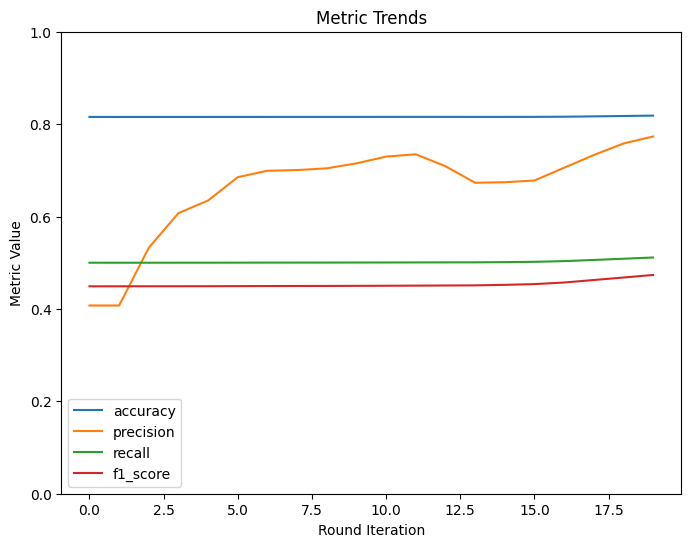

In [28]:
df = pd.DataFrame(dsMetrics.loc[dsMetrics['class'] == "avg"][metrics])

# Set the 'round_iteration' column as the index (optional)
df.set_index('round_iteration', inplace=True)

# Plot the line plot
ax = df.plot(kind='line',  figsize=(8, 6))
ax.set_ylim(0, 1)

# Set the labels and title
plt.xlabel('Round Iteration')
plt.ylabel('Metric Value')
plt.title('Metric Trends')

# Display the plot
plt.show()

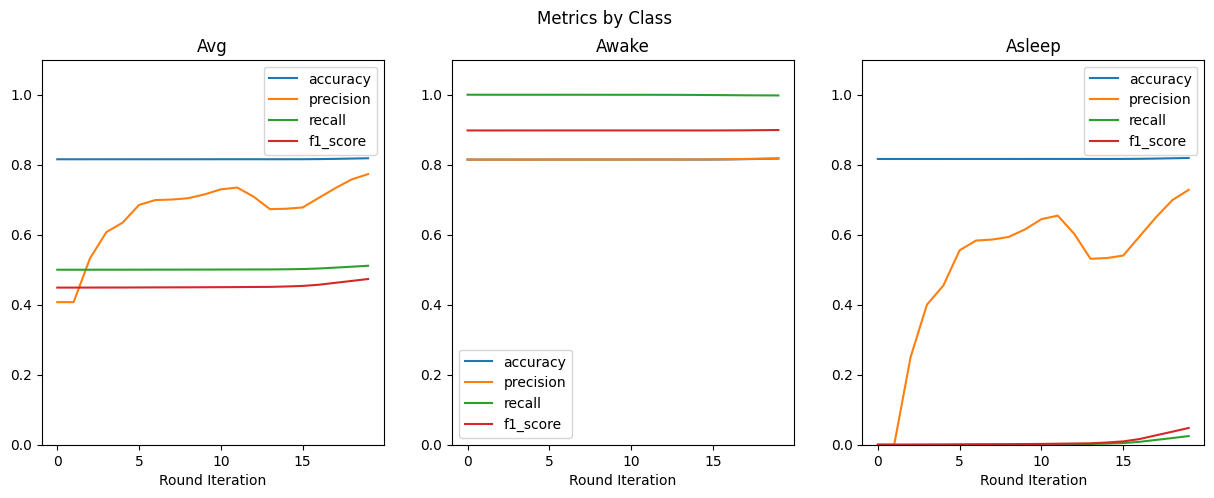

In [29]:
import matplotlib.pyplot as plt

# Define the metrics and classes to plot
metrics = ['round_iteration', 'accuracy', 'precision', 'recall', 'f1_score']
classes = ['avg', 'awake', 'asleep']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop through the classes and plot each one on a different subplot
for i, class_name in enumerate(classes):
    # Filter the data for the current class
    df_class = dsMetrics.loc[dsMetrics['class'] == class_name]
    
    # Plot the metrics on the current subplot
    df_class[metrics].plot.line(x='round_iteration', ax=axes[i])
    axes[i].set_title(class_name.capitalize())
    axes[i].set_xlabel('Round Iteration')
    axes[i].set_ylim([0, 1.1])
    
# Add a title for the entire plot
plt.suptitle('Metrics by Class')

# Show the plot
plt.show()